# CSC 180 Assignment 1
## Lucas Saechao

In [6]:
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import csv
import json
import time
import sklearn.feature_extraction.text as sk_extract_feature
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections.abc import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output
import os

if os.name == 'nt':
    import winsound

# Helper Functions:
## encode_text_index
Encodes textual values to indices format.

## ecnode_numeric_zscore
Computes and encodes a given column as its z-score.

## chart_regression
Prints a chart representing the model's regression.

## to_xy
Converts a pandas DataFrame into <x, y> inputs as required for TensorFlow.

In [7]:
# Encode textual values into indices
def encode_text_index(df, name):
    label_encoder = preprocessing.LabelEncoder()
    df[name] = label_encoder.fit_transform(df[name])
    return label_encoder.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd
    
# Regression chart
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten() })
    if sort:
        t.sort_values(by=['y'], inplace=True)
    a = plt.plot(t['pred'].tolist(), label='prediction')
    b = plt.plot(t['y'].tolist(), label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Convert a Pandas DataFrame to the x, y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    
    # Find out the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bit values
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Filter out business with less than 20 reviews
For each business in which its 'review_count' value is greater than 20, write to a tab separated values (tsv) file its ID, star rating, and review count. The resulting file is then read into a pandas DataFrame and printed for verification.

In [8]:
outfile = open("business.tsv", 'w', encoding='utf-8')
data_file = csv.writer(outfile, delimiter="\t", quoting=csv.QUOTE_MINIMAL)
data_file.writerow(['business_id', 'name', 'stars', 'review_count'])

# Open data from file path
with open('data/yelp_academic_dataset_business.json', encoding="utf-8") as f:
    for line in f:
        row = json.loads(line)
        if (row['review_count'] >= 20):
            data_file.writerow([row['business_id'], row['name'], row['stars'], (row['review_count'])])

outfile.close()

In [9]:
# Create pandas dataframe output file
df_business = pd.read_csv('business.tsv', delimiter="\t", encoding="utf-8")
df_all = df_business[['business_id', 'name', 'stars', 'review_count']]
df_stars = df_business[['business_id', 'name', 'stars']]
df_reviews = df_business[['business_id', 'name','review_count']]
print (df_business)
print (df_stars)
print (df_reviews)

                  business_id                           name  stars  \
0      f9NumwFMBDn751xgFiRbNA       The Range At Lake Norman    3.5   
1      51M2Kk903DFYI6gnB5I6SQ        USE MY GUY SERVICES LLC    4.5   
2      cKyLV5oWZJ2NudWgqs8VZw    Oasis Auto Center - Gilbert    4.5   
3      oiAlXZPIFm2nBCt0DHLu_Q           Green World Cleaners    3.5   
4      uZuh51lXu7tsrC8RAwkg1A                 Manolo Blahnik    4.5   
...                       ...                            ...    ...   
66112  YZeUH6zYS0dq5QHLYZhUnQ                        Hooters    2.0   
66113  xVpE01l6ZXdEtVf5PkRpDg                          Julep    4.0   
66114  fNil19SUfPAPnLQrYnFrGQ  Cheyenne West Animal Hospital    4.5   
66115  JjcJVqhZXhP4tvOhg3fnag              Water Heater Pros    5.0   
66116  SYa2j1boLF8DcGVOYfHPcA                      Five Guys    3.5   

       review_count  
0                36  
1                26  
2                38  
3                81  
4                32  
...            

# Filter out review text by business and star rating
Choose a few arbitrary businesses to fetch reviews for, and map them into a dictionary. For each business in ```yelp_academic_dataset_review.json```, if its ID exists in ```business_map```, write its ID, star rating, and review text to ```reviews_by_stars.tsv```.

In [10]:
# Arbitrarily choose businesses to search reviews for
#business_map = {'SYa2j1boLF8DcGVOYfHPcA':'Five Guys', 'JjcJVqhZXhP4tvOhg3fnag':'Water Heater Pros', 'fNil19SUfPAPnLQrYnFrGQ':'Cheyenne West Animal Hospital', 'xVpE01l6ZXdEtVf5PkRpDg':'Julep', 'YZeUH6zYS0dq5QHLYZhUnQ':'Hooters'}

# write a tsv file with review text
outfile = open('reviews_by_stars.tsv', 'w', encoding='utf-8')
file_writer = csv.writer(outfile, delimiter = "\t", quoting=csv.QUOTE_MINIMAL)
file_writer.writerow(['business_id', 'stars', 'text'])

# Open data from path
with open('data/yelp_academic_dataset_review.json', encoding="utf-8") as f:
    i = 0
    for line in f:
        i += 1
        row = json.loads(line)
        file_writer.writerow( [row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()
winsound.Beep(2000, 300)
winsound.Beep(2000, 300)
winsound.Beep(2000, 300)

In [11]:
# Create pandas dataframe output file
df = pd.read_csv('reviews_by_stars.tsv', delimiter = "\t", encoding = "utf-8")
print(df)

                    business_id  stars  \
0        -MhfebM0QIsKt87iDN-FNw    2.0   
1        lbrU8StCq3yDfr-QMnGrmQ    1.0   
2        HQl28KMwrEKHqhFrrDqVNQ    5.0   
3        5JxlZaqCnk1MnbgRirs40Q    1.0   
4        IS4cv902ykd8wj1TR0N3-A    4.0   
...                         ...    ...   
8021117  XW2kaXdahICaJ27A0dhGHg    1.0   
8021118  IsoLzudHC50oJLiEWpwV-w    3.0   
8021119  kDCyqlYcstqnoqnfBRS5Og    5.0   
8021120  VKVDDHKtsdrnigeIf9S8RA    3.0   
8021121  2SbyRgHWuWNlq18eHAx95Q    5.0   

                                                      text  
0        b'As someone who has worked with many museums,...  
1        b'I am actually horrified this place is still ...  
2        b"I love Deagan's. I do. I really do. The atmo...  
3        b'Dismal, lukewarm, defrosted-tasting "TexMex"...  
4        b'Oh happy day, finally have a Canes near my c...  
...                                                    ...  
8021117  b"Fricken unbelievable, I ordered 2 space heat...  
8021118

# Prepare data for language processing
For each business, aggregate its review data into a single column, and merge the resulting DataFrame with its corresponding star rating.

In [12]:
df_aggregate_reviews = df.groupby('business_id')['text'].sum()
df_reviews_by_stars = pd.merge(df_aggregate_reviews, df_stars, on = 'business_id')
print(df_reviews_by_stars)

                  business_id  \
0      --1UhMGODdWsrMastO9DZw   
1      --6MefnULPED_I942VcFNA   
2      --7zmmkVg-IMGaXbuVd0SQ   
3      --9e1ONYQuAa-CB_Rrw7Tw   
4      --DaPTJW3-tB1vP-PfdTEg   
...                       ...   
66112  zzsOLFhgUw8gnjLTVVItFA   
66113  zzwaS0xn1MVEPEf0hNLjew   
66114  zzwhN7x37nyjP0ZM8oiHmw   
66115  zzwicjPC9g246MK2M1ZFBA   
66116  zzzaIBwimxVej4tY6qFOUQ   

                                                    text  \
0      b'If you are looking for authentic Mexican str...   
1      b"The bbq pork is very juicy and I only come h...   
2      b"I'm a tad reluctant to write a review as I r...   
3      b"On yelp 5 stars = Woohoo! as good as it gets...   
4      b"I used to come to this restaurant about two ...   
...                                                  ...   
66112  b"I'm usually not a big fan of Mexican pastrie...   
66113  b'Though, I never had a friend with a grandma ...   
66114  b'This place is a hidden gem! The pickle fries...   
661

# Prepare TF-IDF Vectorizer
Prepare the vectorizer and fit it to the merged ```df_reviews_by_stars``` DataFrame, and apply it to the review column. After the TF-IDF vectorizer is run, merge it with the original data frame by its review text, and drop any unnecessary columns to prepare a DataFrame for the neural network.

In [13]:
tfidf_vectorizer = sk_extract_feature.TfidfVectorizer(stop_words='english', max_features=1000, min_df=1)
review_vector = tfidf_vectorizer.fit_transform(df_reviews_by_stars['text'])

df_vectorized_reviews = pd.DataFrame(review_vector.toarray())
df_concat_reviews = pd.concat([df_reviews_by_stars, df_vectorized_reviews], axis=1)
businesses = df_concat_reviews['name']

df_neural_network = df_concat_reviews.drop(['business_id', 'text', 'name'], axis=1)
print(df_neural_network)

       stars         0         1        2         3         4         5  \
0        4.0  0.000000  0.008077  0.00000  0.025287  0.045352  0.009443   
1        3.0  0.022653  0.012184  0.00000  0.014304  0.008551  0.017806   
2        4.0  0.000000  0.012599  0.00000  0.000000  0.011790  0.004910   
3        4.0  0.005462  0.013115  0.00976  0.005132  0.005707  0.007053   
4        4.0  0.000000  0.028655  0.00000  0.008971  0.008045  0.006700   
...      ...       ...       ...      ...       ...       ...       ...   
66112    4.5  0.000000  0.025896  0.00000  0.000000  0.000000  0.015138   
66113    3.5  0.006621  0.013354  0.01352  0.006968  0.000000  0.015612   
66114    4.0  0.000000  0.013746  0.00000  0.000000  0.006432  0.000000   
66115    3.0  0.007472  0.027629  0.00000  0.003932  0.000000  0.005873   
66116    3.5  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   

              6        7         8  ...       990      991       992  \
0      0.000000  0.00000  0

In [14]:
# Prepare text dummy
x, y = to_xy(df_neural_network, "stars")

# Split training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state = 40)

# Print data shape
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(33058, 1000)
(33058,)
(33059, 1000)
(33059,)


# Prepare Neural Network

In [15]:
model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(250, activation='sigmoid'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=2, mode='auto')
checkpoint = ModelCheckpoint(filepath="weight/best_weights.hdf5")

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpoint], verbose=2, epochs=1000)

model.load_weights("weight/best_weights.hdf5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 33058 samples, validate on 33059 samples
Epoch 1/1000
33058/33058 - 6s - loss: 0.1780 - val_loss: 0.0864
Epoch 2/1000
33058/33058 - 2s - loss: 0.0795 - val_loss: 0.0781
Epoch 3/1000
33058/33058 - 2s - loss: 0.0711 - val_loss: 0.0728
Epoch 4/1000
33058/33058 - 2s - loss: 0.0672 - val_loss: 0.0728
Epoch 5/1000
33058/33058 - 2s - loss: 0.0660 - val_loss: 0.0682
Epoch 6/1000
33058/33058 - 2s - loss: 0.0654 - val_loss: 0.0699
Epoch 7/1000
33058/33058 - 2s - loss: 0.0639 - val_loss: 0.0711
Epoch 8/1000
33058/33058 - 2s - loss: 0.0628 - val_loss: 0.0679
Epoch 9/1000
33058/33058 - 2s - loss: 0.0608 - val_loss: 0.0724
Epoch 10/1000
33058/33058 - 2s - loss: 0.0598 - val_loss: 0.0702
Epoch 11/1000
33058/33058 - 2s - loss: 0.0589 - val_loss: 0.0692
Epoch 12/1000
33058/33058 - 3s - loss: 0.0579 - val_loss: 0.0698
Epoch 13/1000
33058/33058 - 2s - loss: 0.0565 - val_loss: 0.0

In [16]:
pred_test = model.predict(x_test)
print("Shape: {}".format(pred_test.shape))
print(pred_test)

pred_train = model.predict(x_train)
print(pred_train)

Shape: (33059, 1)
[[4.3929768]
 [3.2307346]
 [4.386558 ]
 ...
 [4.475309 ]
 [2.6015103]
 [4.148482 ]]
[[2.2975726]
 [2.8817348]
 [3.2957222]
 ...
 [3.5922573]
 [1.9834926]
 [3.865971 ]]


# Measure RMSE error
Root Means Squared Error is commonly used to analyze results of regression problems.

In [17]:
rmse = np.sqrt(metrics.mean_squared_error(pred_test, y_test))
print("Root Means Squared Error: {}".format(rmse))

Root Means Squared Error: 0.29757821559906006


In [18]:
for i in range(5):
    print("{}. Business: {}, Rating: {}, Predicted Rating: {}".format(i + 1, businesses[i], y[i], pred_test[i]))

1. Business: The Spicy Amigos, Rating: 4.0, Predicted Rating: [4.3929768]
2. Business: John's Chinese BBQ Restaurant, Rating: 3.0, Predicted Rating: [3.2307346]
3. Business: Primal Brewery, Rating: 4.0, Predicted Rating: [4.386558]
4. Business: Delmonico Steakhouse, Rating: 4.0, Predicted Rating: [3.0757666]
5. Business: Sunnyside Grill, Rating: 4.0, Predicted Rating: [3.740319]


In [19]:
for i in range(5):
    print("{}. Business: {}, Rating: {}, Predicted Rating: {}".format(i, businesses[i], y[i], pred_train[i]))

0. Business: The Spicy Amigos, Rating: 4.0, Predicted Rating: [2.2975726]
1. Business: John's Chinese BBQ Restaurant, Rating: 3.0, Predicted Rating: [2.8817348]
2. Business: Primal Brewery, Rating: 4.0, Predicted Rating: [3.2957222]
3. Business: Delmonico Steakhouse, Rating: 4.0, Predicted Rating: [3.8166554]
4. Business: Sunnyside Grill, Rating: 4.0, Predicted Rating: [2.6089947]


# Print prediction
Merge the prediction and test columns together and print them.

In [20]:
df_y_test = pd.DataFrame(y_test, columns=['ground_truth'])
df_predicted = pd.DataFrame(pred_test, columns=['predicted'])
prediction_result = pd.concat([df_y_test, df_predicted], axis=1)
prediction_result

,ground_truth,predicted
0,4.0,4.392977
1,3.5,3.230735
2,4.5,4.386558
3,3.0,3.075767
4,3.5,3.740319
...,...,...
33054,3.5,3.056582
33055,4.0,4.042161
33056,5.0,4.475309
33057,3.0,2.601510


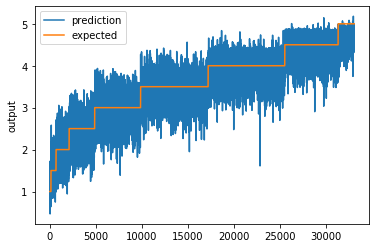

In [21]:
chart_regression(pred_test.flatten(), y_test, sort=True)

In [22]:
winsound.Beep(2000, 300)